In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
from sklearn.preprocessing    import StandardScaler
from sklearn.model_selection  import train_test_split
from sklearn.model_selection  import GridSearchCV
from sklearn.model_selection  import cross_validate

from sklearn.neighbors        import KNeighborsClassifier
from sklearn.ensemble         import RandomForestClassifier
from sklearn.ensemble         import GradientBoostingClassifier
from sklearn.ensemble         import AdaBoostClassifier
from sklearn.svm              import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes      import GaussianNB

from sklearn.ensemble         import VotingClassifier

In [3]:
# Loading the cleaned dataset, in which within-mouse outliers have been removed and then the MEDIAN per mouse has been calculated
# Outlier biological replicates are still present.  Some mice are missing data for some proteins.
# (8/76 proteins are missing at least one data point.)
data = pd.read_csv('Data_Cortex_Nuclear_Medians_Clean.csv')
data.replace(to_replace={'C/S': 'Learning', 'S/C': 'Control'}, inplace=True)
data.head()

,Genotype,Behavior,Treatment,class,Mouse,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,...,pGSK3B_Tyr216_N,SHH_N,BAD_N,BCL2_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N
0,Control,Learning,Memantine,c-CS-m,309,0.416923,0.564036,0.355124,2.260135,4.268735,...,0.833277,0.191561,0.141013,NaN,0.111483,0.434154,0.130405,0.155612,0.158235,1.675652
1,Control,Learning,Memantine,c-CS-m,311,0.591572,0.690271,0.320853,2.285938,4.229412,...,0.679241,0.181889,0.167400,0.168637,NaN,0.430309,0.147208,0.215089,0.197067,1.219966
2,Control,Learning,Memantine,c-CS-m,320,0.530855,0.748072,0.385529,2.606780,5.601210,...,0.854093,0.220316,0.161053,0.136110,0.123425,0.534845,0.143169,0.180373,NaN,1.638988
3,Control,Learning,Memantine,c-CS-m,321,0.420542,0.640420,0.357512,2.731909,5.468987,...,0.922769,0.234360,NaN,0.160967,NaN,0.561673,0.152119,0.214380,NaN,1.682427
4,Control,Learning,Memantine,c-CS-m,322,0.356514,0.500887,0.316709,2.062867,4.128476,...,0.829548,0.239625,NaN,0.150934,0.140960,0.494885,NaN,NaN,NaN,1.614975


In [4]:
# identify which columns represent protein names
not_a_protein = ['Genotype','Behavior','Treatment','class', 'Mouse']
protein_names = data.columns[5:]
y_class = data['class']

In [5]:
# Identify X columns, then impute medians for missing values and scale all values
X_columns = data[protein_names]
medians = X_columns.median()
X_imputed = X_columns.fillna(medians)
scaler = StandardScaler()
scaler.fit(X_imputed)
X_scaled = scaler.transform(X_imputed)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y_class, 
                                                    test_size = 0.2, stratify = y_class)

In [7]:
#Nearest Neighbors hyperparameters
param_grid = {'n_neighbors': [2,3,4,5,7,9,10,11,12,15,20]}
classifier = KNeighborsClassifier()
cv = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 4, iid = False, return_train_score=False)
cv.fit(X_train, Y_train)
pd.DataFrame(cv.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
4,{'n_neighbors': 7},0.420833
1,{'n_neighbors': 3},0.418750
2,{'n_neighbors': 4},0.410417
3,{'n_neighbors': 5},0.388542
5,{'n_neighbors': 9},0.379167
6,{'n_neighbors': 10},0.379167
9,{'n_neighbors': 15},0.372917
8,{'n_neighbors': 12},0.365625
7,{'n_neighbors': 11},0.341667
0,{'n_neighbors': 2},0.331250


In [8]:
# SVM hyperparameters
param_grid = {'C': [1, 10, 100, 1000], 'gamma': ['scale'], 'kernel': ['linear','rbf']}
classifier = SVC()
cv = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 4, iid = False, return_train_score=False)
cv.fit(X_train, Y_train)
pd.DataFrame(cv.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
0,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.677083
2,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.677083
4,"{'C': 100, 'gamma': 'scale', 'kernel': 'linear'}",0.677083
6,"{'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}",0.677083
3,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.590625
5,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.590625
7,"{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",0.590625
1,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.493750


In [9]:
# Naive Bayes hyperparameters
param_grid = {'var_smoothing': [
    0.00000000001,
    0.0000000001,
    0.000000001,
    0.00000001,
    0.0000001,
    0.000001,
    0.00001,
    0.0001,
    0.001,
    0.01,
    0.1,
    1,
    10]}
classifier = GaussianNB()
cv = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 4, iid = False, return_train_score=False)
cv.fit(X_train, Y_train)
pd.DataFrame(cv.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending = False)

,params,mean_test_score
10,{'var_smoothing': 0.1},0.460417
0,{'var_smoothing': 1e-11},0.434375
1,{'var_smoothing': 1e-10},0.434375
2,{'var_smoothing': 1e-09},0.434375
3,{'var_smoothing': 1e-08},0.434375
4,{'var_smoothing': 1e-07},0.434375
5,{'var_smoothing': 1e-06},0.434375
6,{'var_smoothing': 1e-05},0.434375
7,{'var_smoothing': 0.0001},0.434375
8,{'var_smoothing': 0.001},0.434375


In [21]:
classifier_nn = KNeighborsClassifier(n_neighbors = 10)
classifier_rf = RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', n_estimators = 1000, 
                                       max_depth = None, n_jobs = -1, min_samples_leaf = 1)
classifier_gb = GradientBoostingClassifier(n_estimators = 1000, subsample = 0.8, max_depth = 10)
classifier_ab = AdaBoostClassifier(n_estimators = 1000)
classifier_sv = SVC(C = 10, gamma = 'scale', kernel = 'linear')
classifier_nb = GaussianNB(var_smoothing = 0.1)
classifier_gp = GaussianProcessClassifier()

classifiers = [('Nearest Neighbors', classifier_nn),
               ('Random Forest', classifier_rf),
               ('Gradient Boost', classifier_gb), 
               ('AdaBoost', classifier_ab),
               ('Support Vector', classifier_sv),
               ('Naive Bayes', classifier_nb),
               ('Gaussian Process', classifier_gp)]

In [26]:
scores = []
for (name, classifier) in classifiers:
    cv_scores = cross_validate(classifier, X_train, Y_train, cv = 4, return_train_score = False)
    mean_score = np.mean(cv_scores['test_score'])
    print(name, mean_score)
    scores.append(mean_score)
    

NN 0.37916666666666665
RF 0.5229166666666667
GB 0.4260416666666667
AB 0.29166666666666663
SV 0.6770833333333334
NB 0.4604166666666667
GP 0.5197916666666667


In [29]:
classifier_voting = VotingClassifier(estimators = classifiers, voting='hard', weights=scores, n_jobs=-1)
classifier_voting.fit(X_train, Y_train)
training_accuracy = classifier_voting.score(X_train, Y_train)
test_accuracy = classifier_voting.score(X_test, Y_test)
print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 1.000000
Accuracy on test data:     0.533333


In [34]:
# Function to read class label and deconvolve it into the 3 variables
def interpret_class(class_str):
    class_split = class_str.split('-')
    if (class_split[0] == 'c'):
        genotype = 'Control'
    else:
        genotype = 'Ts65Dn'    
    if (class_split[1] == 'SC'):
        behavior = 'Control'
    else:
        behavior = 'Learning'    
    if (class_split[2] == 's'):
        treatment = 'Saline'
    else:
        treatment = 'Memantine'
    return {'Genotype' : genotype, 
            'Behavior' : behavior,
            'Treatment': treatment}

{'Genotype': 'Control', 'Behavior': 'Learning', 'Treatment': 'Memantine'}

In [60]:
# Look for how the classifier did on each of the 3 variables (Genotype, Behavior, and Treatment)
def divide_score(classifier):
    Y_pred = classifier.predict(X_test)
    Y_test_divided = pd.DataFrame([interpret_class(y) for y in Y_test])
    Y_pred_divided = pd.DataFrame([interpret_class(y) for y in Y_pred])
    genotype_accuracy  = np.mean(Y_test_divided.Genotype == Y_pred_divided.Genotype)
    behavior_accuracy  = np.mean(Y_test_divided.Behavior == Y_pred_divided.Behavior)
    treatment_accuracy = np.mean(Y_test_divided.Treatment == Y_pred_divided.Treatment)
    overall_accuracy = np.mean(Y_test == Y_pred)
    return {'Genotype_Accuracy' : genotype_accuracy, 
            'Behavior_Accuracy' : behavior_accuracy,
            'Treatment_Accuracy': treatment_accuracy,
            'Overall_Accuracy':   overall_accuracy}
divided_score = divide_score(classifier_voting)
print('Test accuracy at predicting genotype:  %0.1f%%' %(divided_score['Genotype_Accuracy']*100))
print('Test accuracy at predicting behavior:  %0.1f%%' %(divided_score['Behavior_Accuracy']*100))
print('Test accuracy at predicting treatment: %0.1f%%' %(divided_score['Treatment_Accuracy']*100))

Test accuracy at predicting genotype:  60.0%
Test accuracy at predicting behavior:  100.0%
Test accuracy at predicting treatment: 73.3%


In [65]:
#Do any classifiers do better at genotype and treatment?
accuracy_scores = []
names = []
for (name, classifier) in classifiers:
    classifier.fit(X_train, Y_train)
    names.append(name)
    accuracy_scores.append(divide_score(classifier))

In [67]:
accuracy_df = pd.DataFrame(accuracy_scores, index = names)
accuracy_df = accuracy_df.reindex(columns=['Genotype_Accuracy', 'Behavior_Accuracy', 'Treatment_Accuracy', 'Overall_Accuracy'])
accuracy_df.sort_values('Genotype_Accuracy', ascending = False)

,Genotype_Accuracy,Behavior_Accuracy,Treatment_Accuracy,Overall_Accuracy
GP,0.666667,0.800000,0.666667,0.400000
NN,0.600000,0.733333,0.333333,0.200000
SV,0.600000,0.933333,0.800000,0.466667
NB,0.600000,1.000000,0.666667,0.466667
RF,0.533333,1.000000,0.733333,0.466667
GB,0.533333,0.666667,0.533333,0.266667
AB,0.533333,1.000000,0.533333,0.266667


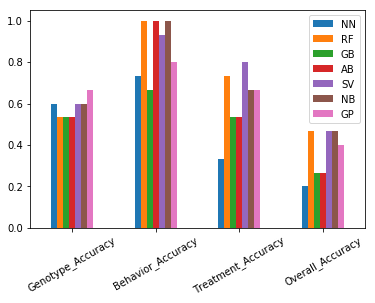

In [72]:
_ = accuracy_df.transpose().plot(kind = 'bar', rot = 30)